In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from preprocessing import DataTransform, DataPreprocessor
from data_stats import Plotter, DataFrameInfo
from sklearn.preprocessing import LabelEncoder


In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
raw_data = pd.read_csv("RDS_data.csv", index_col=0)
pre_processing_data = DataPreprocessor(raw_data)
# skew_inspection = Plotter(data_transformer.data)


Using regressor to impute for column: funded_amount
Mean Absolute Error: 0.9051416271219608 for predictions on funded_amount column
Imputation for funded_amount complete!
Using classifier to impute for column: term
Mean Absolute Error: 0.7716862586137008 for predictions on term column
Imputation for term complete!
Using regressor to impute for column: int_rate
Mean Absolute Error: 0.0001629565306501336 for predictions on int_rate column
Imputation for int_rate complete!


In [3]:
pre_processing_data.data.isnull().sum().sum()

NameError: name 'pre_processing_data' is not defined

In [4]:
DataFrameInfo(data_transformer.raw_data).print_all_info()

Datatypes:
loan_id                                object
member_id                              object
loan_amount                             int64
funded_amount                         float64
funded_amount_inv                     float64
term                                   object
int_rate                              float64
installment                           float64
loan_grade                             object
loan_sub_grade                         object
employment_length                       int64
home_ownership                         object
annual_inc                            float64
verification_status                    object
issue_date                     datetime64[ns]
loan_status                            object
payment_plan                             bool
purpose                                object
dti                                   float64
delinq_2yrs                             int64
earliest_credit_line           datetime64[ns]
inq_last_6mths         

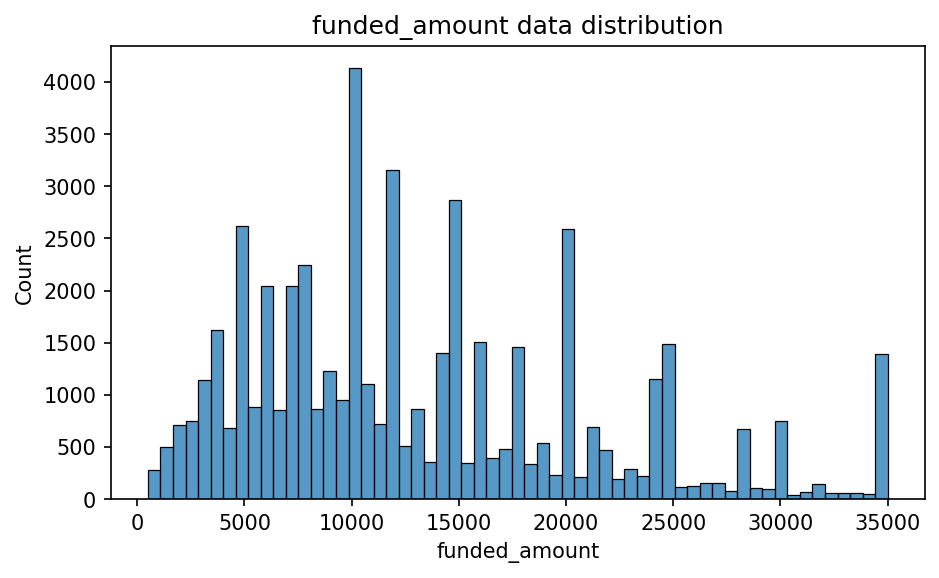

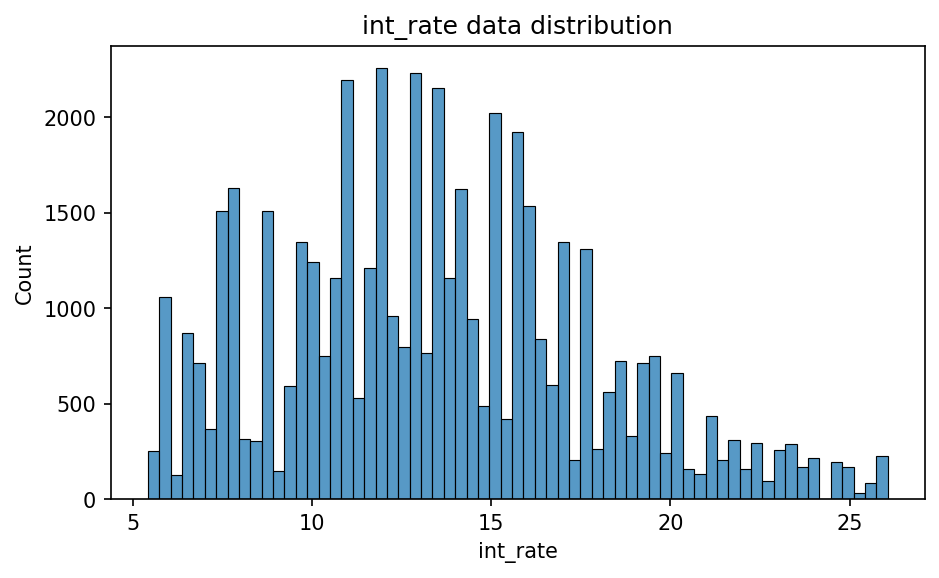

In [5]:
imputation_cols = ["funded_amount","term","int_rate"]
# for col in skew_inspection.df:
for col in imputation_cols:
    if skew_inspection.df[col].dtype == int or skew_inspection.df[col].dtype == float:
        # print(col)
        skew_inspection.plot_hist(col)

In [4]:
for col in skew_inspection.df:
    if skew_inspection.df[col].dtype == int or skew_inspection.df[col].dtype == float:
        print(col)
        # skew_inspection.plot_hist(col)

loan_amount
funded_amount
funded_amount_inv
int_rate
installment
employment_length
annual_inc
dti
delinq_2yrs
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_accounts
total_accounts
out_prncp
out_prncp_inv
total_payment
total_payment_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_payment_amount
collections_12_mths_ex_med
mths_since_last_major_derog


<AxesSubplot:ylabel='Count'>

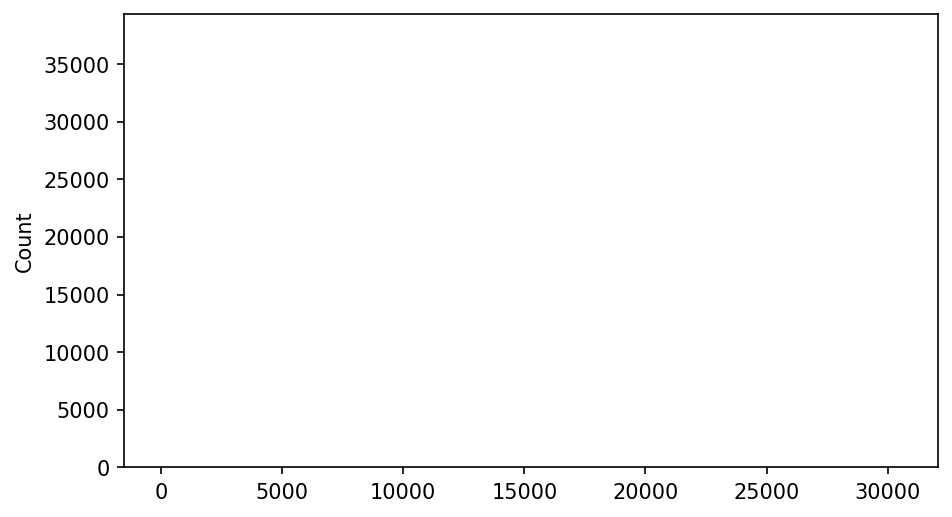

In [11]:
# imputation_cols = ["funded_amount","term","int_rate"]
# for col in skew_inspection.df:
# for col in imputation_cols:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4),dpi=150)
sns.histplot(skew_inspection.df['funded_amount']-skew_inspection.df['funded_amount_inv'])
# sns.histplot(skew_inspection.df['funded_amount_inv'])

In [13]:
print(skew_inspection.df['funded_amount'])
print(skew_inspection.df['funded_amount_inv'])

0         8000.0
1        13200.0
2        16000.0
3        15000.0
4        15000.0
          ...   
54226     5000.0
54227     5000.0
54228     3500.0
54229     5000.0
54230     5000.0
Name: funded_amount, Length: 54231, dtype: float64
0         8000.0
1        13200.0
2        16000.0
3        15000.0
4        15000.0
          ...   
54226     1775.0
54227     2350.0
54228     2225.0
54229      225.0
54230      350.0
Name: funded_amount_inv, Length: 54231, dtype: float64


In [17]:
def impute_nulls_test(data, column_name):
    set_classifier_flag = 0 # flag used later
    # idea taken from a kaggle challenge from a few months ago

    # split data into train/test and null sets - based on target column containing null values
    null_data = data[data[column_name].isnull()]
    non_null_data = data.dropna(subset=[column_name])

    # Feature columns
    feature_cols = [col for col in data.columns if col != column_name]
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # if column_name in numeric_columns:
    #     numeric_columns.remove(column_name)
    # Train model on non-null data
    X_features = non_null_data[numeric_columns]
    y_target = non_null_data[column_name]

    # # Model training
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_columns)])
    if y_target.dtype == object:
        model = RandomForestClassifier()
        print(f"Using classifier to impute for column: {column_name}")
        y_target = pd.get_dummies(y_target)
        new_columns = y_target.columns.tolist()
        set_classifier_flag = 1
    elif y_target.dtype == int or y_target.dtype == float:
        model = RandomForestRegressor()
        print(f"Using regressor to impute for column: {column_name}")
    else:
        print(f"Incorrect data type encountered in column to be imputed: {column_name} ; {y_target.dtype}")

    # Split the data
    X_train, X_verify, y_train, y_verify = train_test_split(X_features, y_target, test_size=0.4, random_state=42)
    X_train = preprocessor.fit_transform(X_train)
    X_verify = preprocessor.transform(X_verify)

    # Train the model
    model.fit(X_train, y_train)
    
    # # Make predictions on the verification set
    predictions = model.predict(X_verify)
    # # Evaluate the model
    mae = mean_absolute_error(y_verify, predictions)
    print(f"Mean Absolute Error: {mae} for predictions on {column_name} column")
    

    # # Impute missing values
    X_null = null_data[numeric_columns]
    X_null = preprocessor.transform(X_null)
    
    # # scaled_X_null = scaler.transform(X_null)
    imputed_values = model.predict(X_null)

    # Replace missing values with imputed values in the original dataset
    if set_classifier_flag:
        data = pd.get_dummies(data, columns=[column_name])
        data.loc[data.index.isin(null_data.index), new_columns] = imputed_values
    else:
        data.loc[data.index.isin(null_data.index), column_name] = imputed_values

    print(f"Imputation for {column_name} complete!")
    # print(imputed_values)
    
    return data



In [18]:
cols_to_impute = ["funded_amount","term","int_rate"]
raw_data = pd.read_csv("RDS_data.csv", index_col=0)
processed_data = DataPreprocessor(raw_data)

In [19]:
data = impute_nulls_test(processed_data.data, cols_to_impute[0])

Using regressor to impute for column: funded_amount
Mean Absolute Error: 0.9225820654566802 for predictions on funded_amount column
Imputation for funded_amount complete!


In [20]:
data

,loan_id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,installment,loan_grade,loan_sub_grade,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.00,36 months,7.49,248.82,A,A4,...,512.21,0.000000,0.0,0.0,2022-01-01,248.82,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.00,36 months,6.99,407.52,A,A3,...,787.94,0.000000,0.0,0.0,2022-01-01,407.52,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.00,36 months,7.49,497.63,A,A4,...,824.54,0.000000,0.0,0.0,2021-10-01,12850.16,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.00,36 months,14.31,514.93,C,C4,...,947.47,0.000000,0.0,0.0,2021-06-01,13899.67,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.00,36 months,6.03,456.54,A,A1,...,770.93,0.000000,0.0,0.0,2022-01-01,456.54,2022-01-01,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54199,55521,107577,1000,1000.0,0.00,36 months,16.08,35.20,F,F2,...,207.77,0.000000,0.0,0.0,2016-03-01,538.97,2016-03-01,0.0,1,INDIVIDUAL
54203,185352,105254,6000,6000.0,502.69,36 months,9.64,192.60,B,B4,...,933.06,0.000000,0.0,0.0,2016-12-01,193.55,2016-12-01,0.0,1,INDIVIDUAL
54204,122637,104675,4000,4000.0,1550.00,36 months,7.75,124.89,A,A3,...,495.79,0.000000,0.0,0.0,2016-09-01,126.29,2016-08-01,0.0,1,INDIVIDUAL
54221,395632,91027,5500,5500.0,5450.00,36 months,13.16,185.74,C,C3,...,303.77,0.000000,0.0,0.0,2016-10-01,85.66,2021-04-01,0.0,1,INDIVIDUAL


In [9]:
data = impute_nulls_test(processed_data.data, cols_to_impute[1])

Using classifier to impute for column: term
Mean Absolute Error: 0.7975020267531414 for predictions on term column
Imputation for term complete!


In [10]:
data = impute_nulls_test(processed_data.data, cols_to_impute[2])

Using regressor to impute for column: int_rate
Mean Absolute Error: 0.00015549369160488814 for predictions on int_rate column
ping
Imputation for int_rate complete!


In [30]:
data.isnull().sum()

loan_id                  0
member_id                0
loan_amount              0
funded_amount         2998
funded_amount_inv        0
                     ...  
int_rate_25.83           0
int_rate_25.89           0
int_rate_25.99           0
int_rate_26.06           0
int_rate             48941
Length: 494, dtype: int64

<AxesSubplot:xlabel='int_rate', ylabel='Count'>

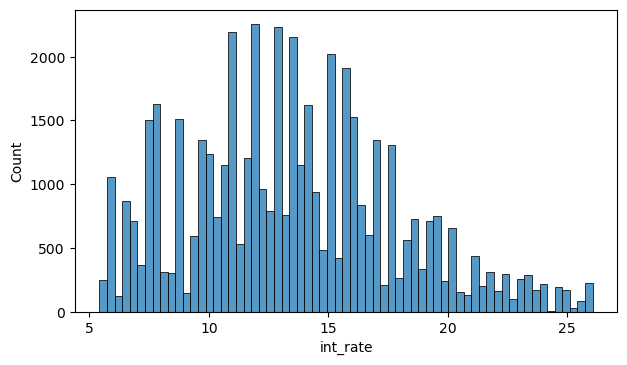

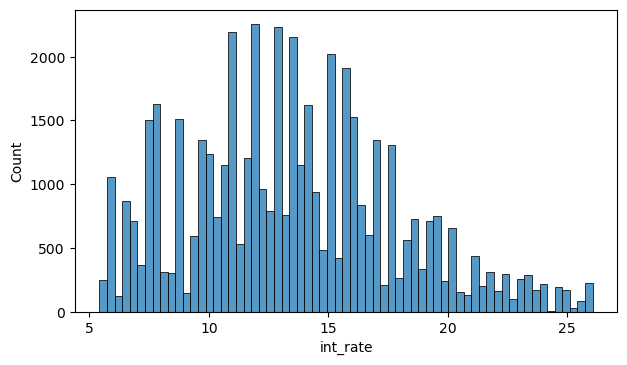

In [69]:
plt.figure(figsize=(7,4),dpi=100)
sns.histplot(processed_data.data['int_rate'])
plt.figure(figsize=(7,4),dpi=100)
sns.histplot(pre_processing_data.data['int_rate'])#[processed_data.data['funded_amount'].isnull()])

In [20]:
processed_data.data['int_rate'].describe()

count    48941.000000
mean        13.507936
std          4.393899
min          5.420000
25%         10.370000
50%         13.160000
75%         16.200000
max         26.060000
Name: int_rate, dtype: float64

In [21]:
# data['int_rate']
data['int_rate'][processed_data.data['int_rate'].isnull()]

15      NaN
19      NaN
73      NaN
77      NaN
79      NaN
         ..
54106   NaN
54118   NaN
54137   NaN
54148   NaN
54160   NaN
Name: int_rate, Length: 5159, dtype: float64

In [56]:
data = pd.get_dummies(processed_data.data, columns=['term'])
data

,loan_id,member_id,loan_amount,funded_amount,funded_amount_inv,int_rate,installment,loan_grade,loan_sub_grade,employment_length,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type,term_36 months,term_60 months
0,38676116,41461848,8000,8000.0,8000.00,7.49,248.82,A,A4,5,...,0.0,0.0,2022-01-01,248.82,2022-01-01,0.0,1,INDIVIDUAL,1,0
1,38656203,41440010,13200,13200.0,13200.00,6.99,407.52,A,A3,9,...,0.0,0.0,2022-01-01,407.52,2022-01-01,0.0,1,INDIVIDUAL,1,0
2,38656154,41439961,16000,16000.0,16000.00,7.49,497.63,A,A4,8,...,0.0,0.0,2021-10-01,12850.16,2021-10-01,0.0,1,INDIVIDUAL,1,0
3,38656128,41439934,15000,15000.0,15000.00,14.31,514.93,C,C4,1,...,0.0,0.0,2021-06-01,13899.67,2021-06-01,0.0,1,INDIVIDUAL,1,0
4,38656121,41439927,15000,15000.0,15000.00,6.03,456.54,A,A1,15,...,0.0,0.0,2022-01-01,456.54,2022-01-01,0.0,1,INDIVIDUAL,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54199,55521,107577,1000,1000.0,0.00,16.08,35.20,F,F2,1,...,0.0,0.0,2016-03-01,538.97,2016-03-01,0.0,1,INDIVIDUAL,1,0
54203,185352,105254,6000,6000.0,502.69,9.64,192.60,B,B4,1,...,0.0,0.0,2016-12-01,193.55,2016-12-01,0.0,1,INDIVIDUAL,1,0
54204,122637,104675,4000,4000.0,1550.00,7.75,124.89,A,A3,1,...,0.0,0.0,2016-09-01,126.29,2016-08-01,0.0,1,INDIVIDUAL,1,0
54221,395632,91027,5500,5500.0,5450.00,13.16,185.74,C,C3,1,...,0.0,0.0,2016-10-01,85.66,2021-04-01,0.0,1,INDIVIDUAL,1,0


In [ ]:
cols_to_impute = ["funded_amount","term","int_rate"]
def impute_nulls_test(data, column_name):
    set_classifier_flag = 0 # flag used later
    # idea taken from a kaggle challenge from a few months ago

    # split data into train/test and null sets - based on target column containing null values
    null_data = data[data[column_name].isnull()]
    non_null_data = data.dropna(subset=[column_name])

    # Feature columns
    feature_cols = [col for col in data.columns if col != column_name]
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # if column_name in numeric_columns:
    #     numeric_columns.remove(column_name)


    # Train model on non-null data
    X_features = non_null_data[numeric_columns]
    y_target = non_null_data[column_name]

    # # Model training
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_columns)])
    
    if y_target.dtype == object:
        model = RandomForestClassifier()
        print(f"Using classifier to impute for column: {column_name}")
        y_target = pd.get_dummies(y_target)
        new_columns = y_target.columns.tolist()
        set_classifier_flag = 1
    elif y_target.dtype == int or y_target.dtype == float:
        model = RandomForestRegressor()
        print(f"Using regressor to impute for column: {column_name}")
    else:
        print(f"Incorrect data type encountered in column to be imputed: {column_name} ; {y_target.dtype}")

    # Split the data
    X_train, X_verify, y_train, y_verify = train_test_split(X_features, y_target, test_size=0.4, random_state=42)
    X_train = preprocessor.fit_transform(X_train)
    X_verify = preprocessor.transform(X_verify)

    # Train the model
    model.fit(X_train, y_train)
    
    # # Make predictions on the verification set
    predictions = model.predict(X_verify)
    # # Evaluate the model
    mae = mean_absolute_error(y_verify, predictions)
    print(f"Mean Absolute Error: {mae} for predictions on {column_name} column")
    

    # # Impute missing values
    X_null = null_data[numeric_columns]
    X_null = preprocessor.transform(X_null)
    
    # # scaled_X_null = scaler.transform(X_null)
    imputed_values = model.predict(X_null)

    # Replace missing values with imputed values in the original dataset
    data = pd.get_dummies(data, columns=[column_name])
    if set_classifier_flag:
        data.loc[data.index.isin(null_data.index), new_columns] = imputed_values
    else:
        data.loc[data.index.isin(null_data.index), column_name] = imputed_values
        print("ping")

    print(f"Imputation for {column_name} complete!")
    
    
    return data



In [ ]:
# OLD VERSION
def impute_nulls_test(data, column_name):
    set_classifier_flag = 0 # flag used later
    # idea taken from a kaggle challenge from a few months ago

    # split data into train/test and null sets - based on target column containing null values
    null_data = data[data[column_name].isnull()]
    non_null_data = data.dropna(subset=[column_name])

    # Feature columns
    feature_cols = [col for col in data.columns if col != column_name]
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # if column_name in numeric_columns:
    #     numeric_columns.remove(column_name)
    # Train model on non-null data
    X_features = non_null_data[numeric_columns]
    y_target = non_null_data[column_name]

    # # Model training
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_columns)])
    if y_target.dtype == object:
        model = RandomForestClassifier()
        print(f"Using classifier to impute for column: {column_name}")
        y_target = pd.get_dummies(y_target)
        new_columns = y_target.columns.tolist()
        set_classifier_flag = 1
    elif y_target.dtype == int or y_target.dtype == float:
        model = RandomForestRegressor()
        print(f"Using regressor to impute for column: {column_name}")
    else:
        print(f"Incorrect data type encountered in column to be imputed: {column_name} ; {y_target.dtype}")

    # Split the data
    X_train, X_verify, y_train, y_verify = train_test_split(X_features, y_target, test_size=0.4, random_state=42)
    X_train = preprocessor.fit_transform(X_train)
    X_verify = preprocessor.transform(X_verify)

    # Train the model
    model.fit(X_train, y_train)
    
    # # Make predictions on the verification set
    predictions = model.predict(X_verify)
    # # Evaluate the model
    mae = mean_absolute_error(y_verify, predictions)
    print(f"Mean Absolute Error: {mae} for predictions on {column_name} column")
    

    # # Impute missing values
    X_null = null_data[numeric_columns]
    X_null = preprocessor.transform(X_null)
    
    # # scaled_X_null = scaler.transform(X_null)
    imputed_values = model.predict(X_null)

    # Replace missing values with imputed values in the original dataset
    data = pd.get_dummies(data, columns=[column_name])
    if set_classifier_flag:
        data.loc[data.index.isin(null_data.index), new_columns] = imputed_values
    else:
        data.loc[data.index.isin(null_data.index), column_name] = imputed_values
        print("ping")

    print(f"Imputation for {column_name} complete!")
    
    
    return data



In [23]:
raw_data = pd.read_csv('RDS_data.csv')
processed_data = DataPreprocessor(raw_data)
data_for_plotting = Plotter(processed_data.data)

Using regressor to impute for column: funded_amount
Mean Absolute Error: 0.9346044714055085 for predictions on funded_amount column
Imputation for funded_amount complete!
Using classifier to impute for column: term
Mean Absolute Error: 0.7716102553708959 for predictions on term column
Imputation for term complete!
Using regressor to impute for column: int_rate
Mean Absolute Error: 0.00019835521277839443 for predictions on int_rate column
Imputation for int_rate complete!


In [11]:
skew_test_log = np.log(data_for_plotting.df[skewed_cols])

In [32]:
skewness = data_for_plotting.df.skew()

# Filter columns where skewness is beyond a certain threshold (e.g., 1 or -1)
skewed_cols = skewness[abs(skewness) > 1].index.tolist()
print(skewed_cols)

['loan_id', 'member_id', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_payment_inv', 'total_rec_prncp', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount', 'collections_12_mths_ex_med', 'term_60 months', '36 months', '60 months']


/tmp/ipykernel_210680/308082628.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewness = data_for_plotting.df.skew()


In [8]:
skewed_cols = [
 'annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_accounts',
 'out_prncp',
 'out_prncp_inv',
 'int_rate',
 'installment',
 'total_payment',
 'total_payment_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_payment_amount',
 'collections_12_mths_ex_med']

In [25]:
from scipy.stats import boxcox, yeojohnson
# transformed_data = [0,1,1] # initialise for loop
# while transformed_data.skew() > 1:
for column in data_for_plotting.df:
    if data_for_plotting.df.dtypes[column] == float or data_for_plotting.df.dtypes[column] == int:
        
        try:
            transformed_data, _ = yeojohnson(data_for_plotting.df[column].dropna())
            data_for_plotting.df[column] = transformed_data
            print(f"transform success for {column}")
        except ValueError:
            print(f"transform failed for {column}")
            # Handle columns where Box-Cox transformation cannot be applied
            pass

boxcox success for Unnamed: 0
boxcox success for loan_amount
boxcox success for funded_amount
boxcox success for funded_amount_inv
boxcox success for int_rate
boxcox success for installment
boxcox success for employment_length
boxcox success for annual_inc
boxcox success for dti
boxcox success for delinq_2yrs
boxcox success for inq_last_6mths
boxcox success for open_accounts
boxcox success for total_accounts
boxcox success for out_prncp
boxcox success for out_prncp_inv
boxcox success for total_payment
boxcox success for total_payment_inv
boxcox success for total_rec_prncp
boxcox success for total_rec_int
boxcox success for total_rec_late_fee
boxcox success for recoveries
boxcox success for collection_recovery_fee
boxcox success for last_payment_amount
boxcox success for collections_12_mths_ex_med
boxcox failed for 36 months
boxcox failed for 60 months


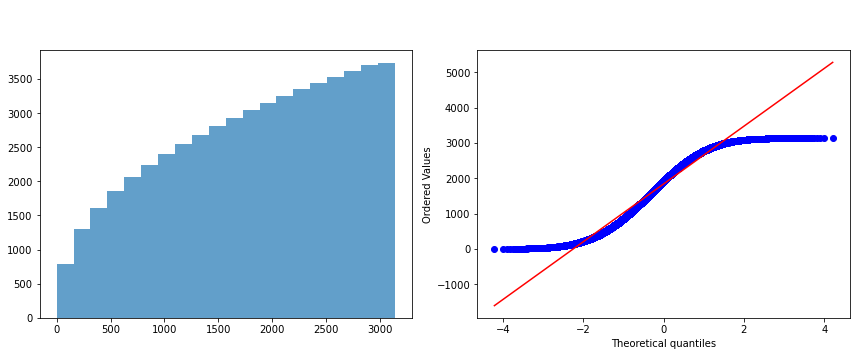

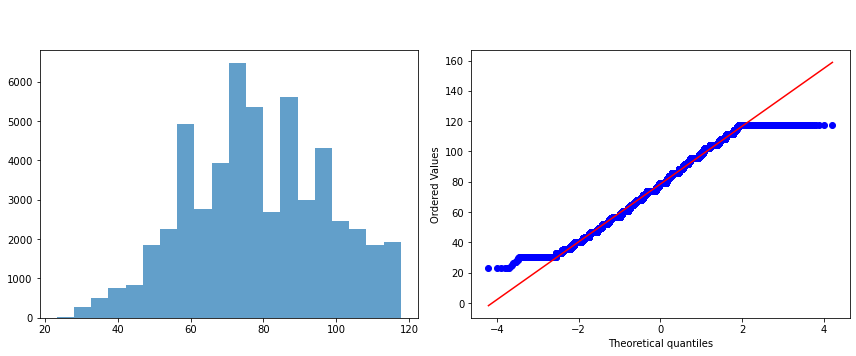

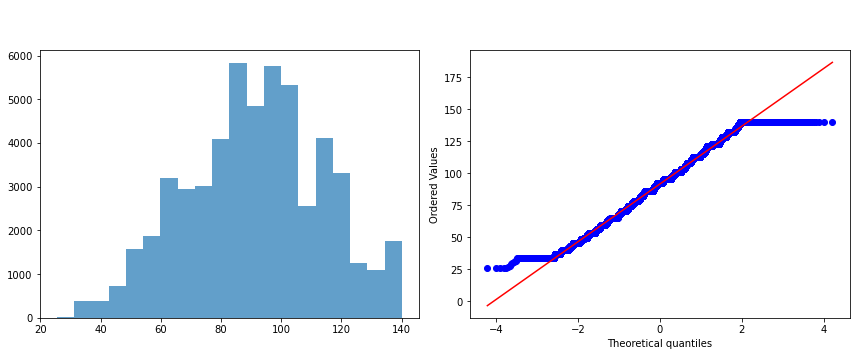

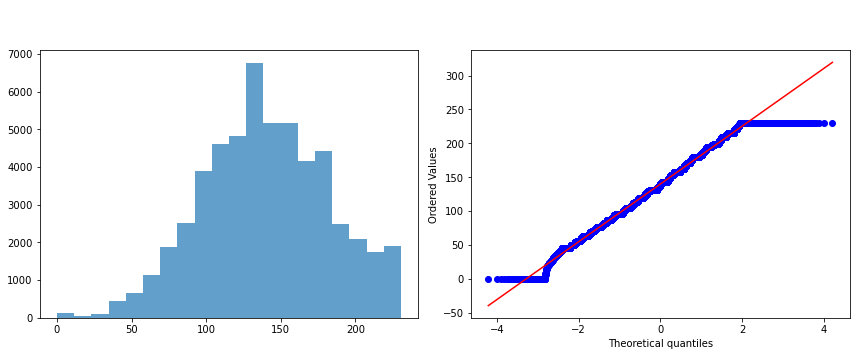

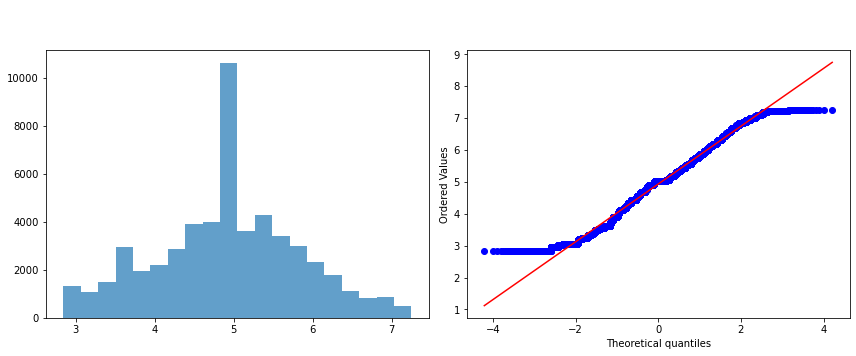

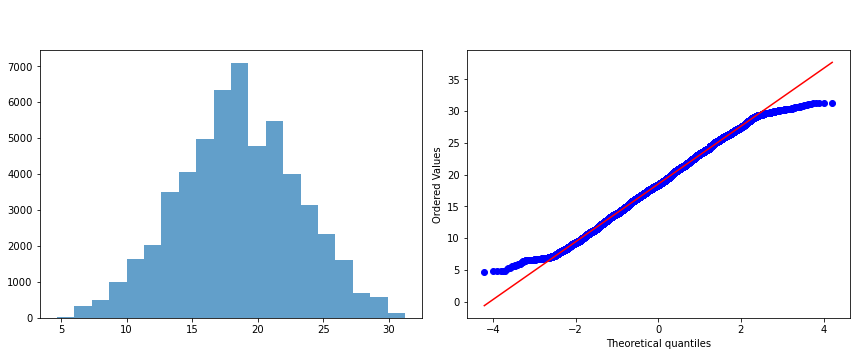

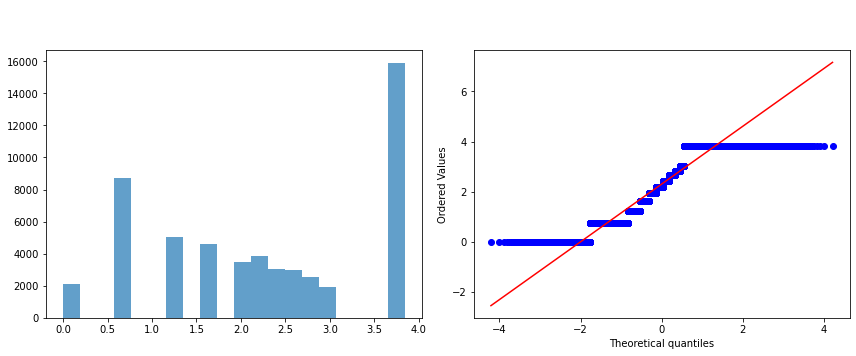

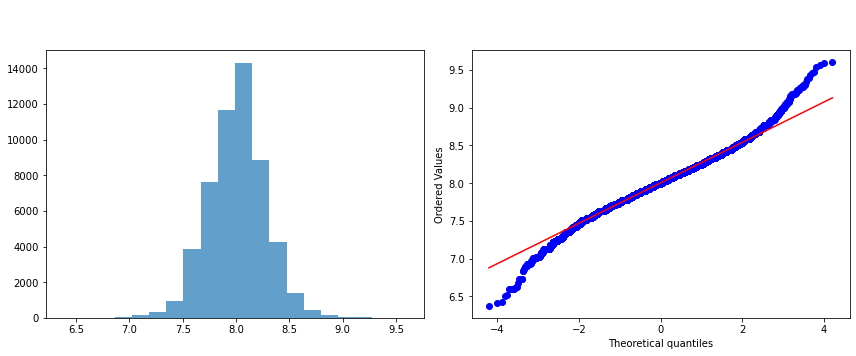

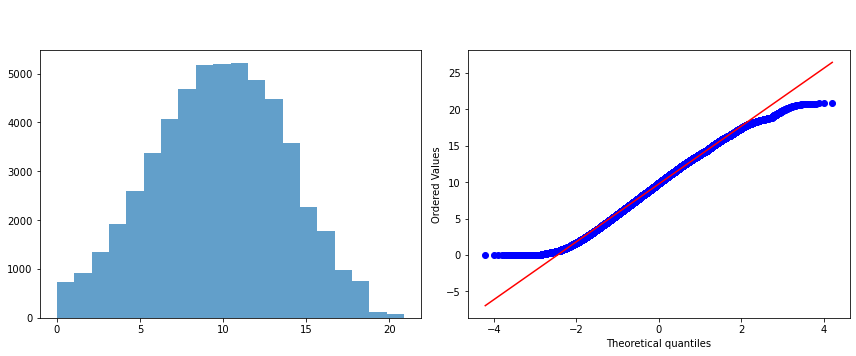

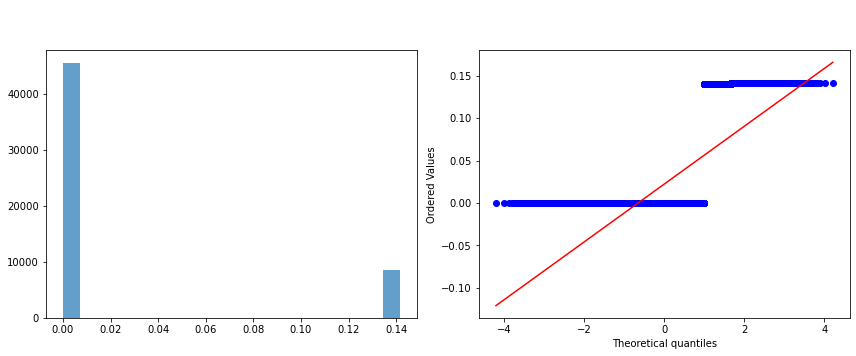

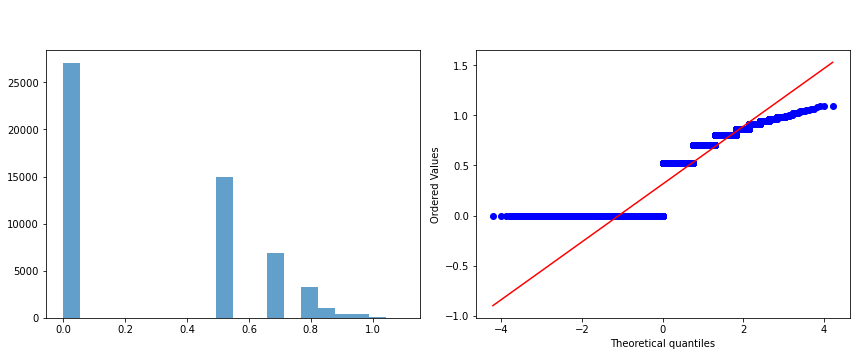

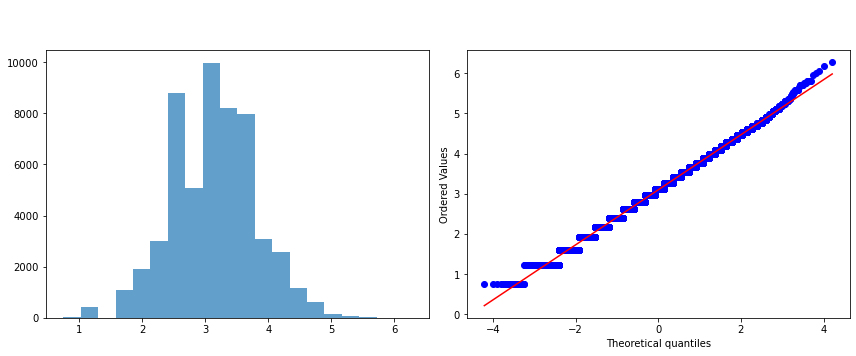

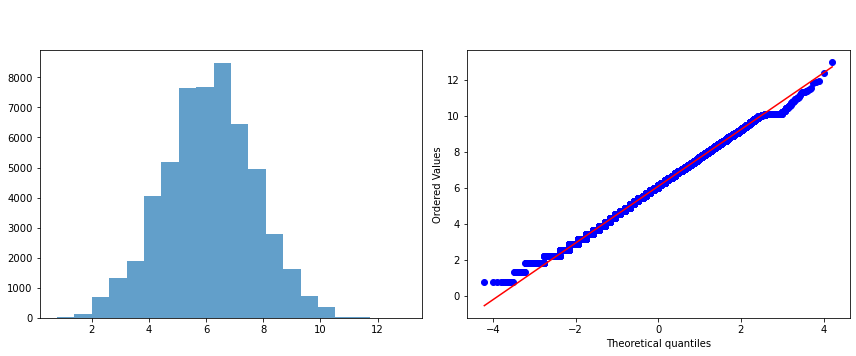

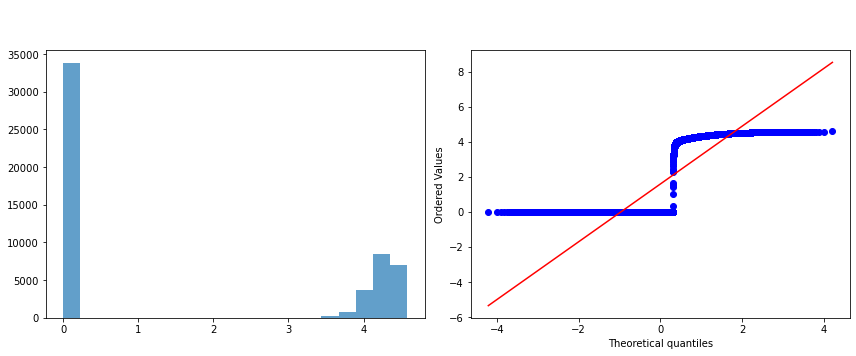

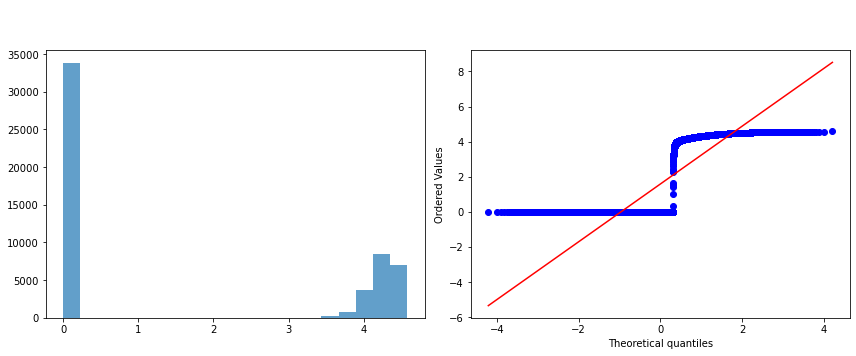

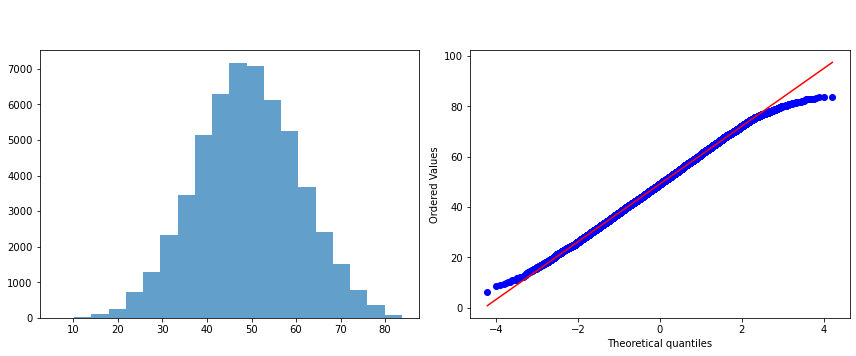

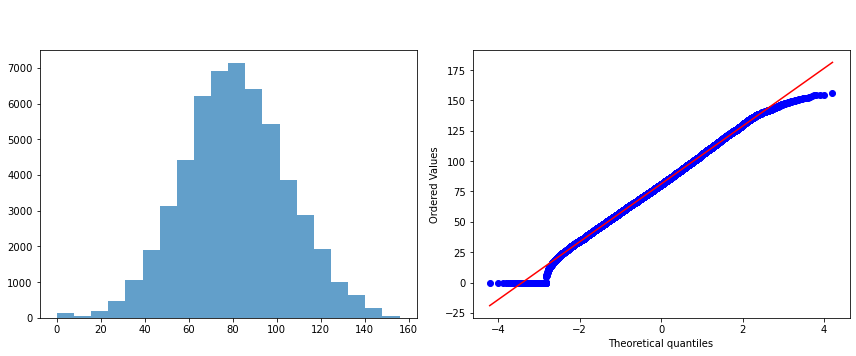

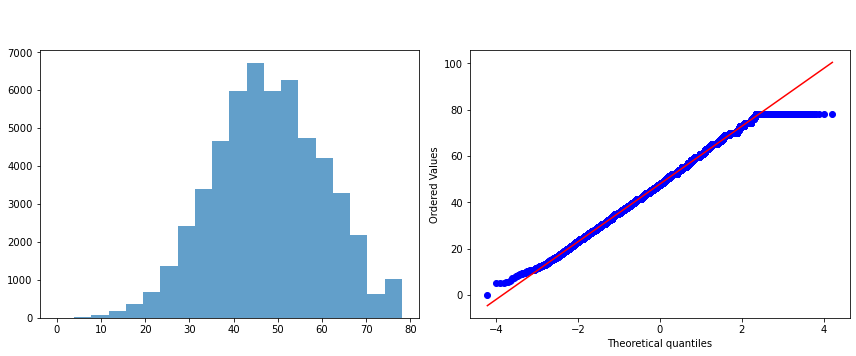

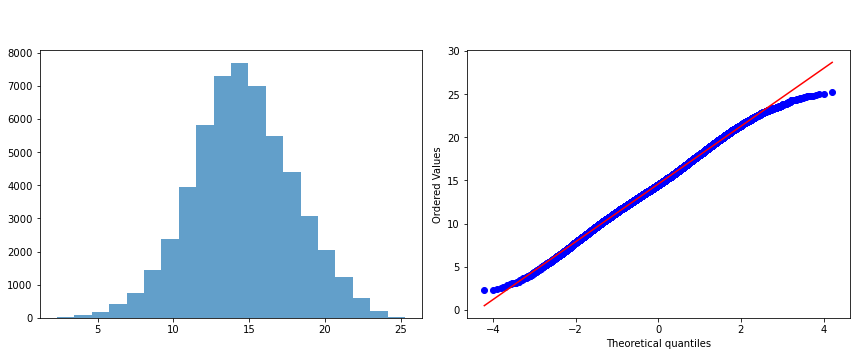

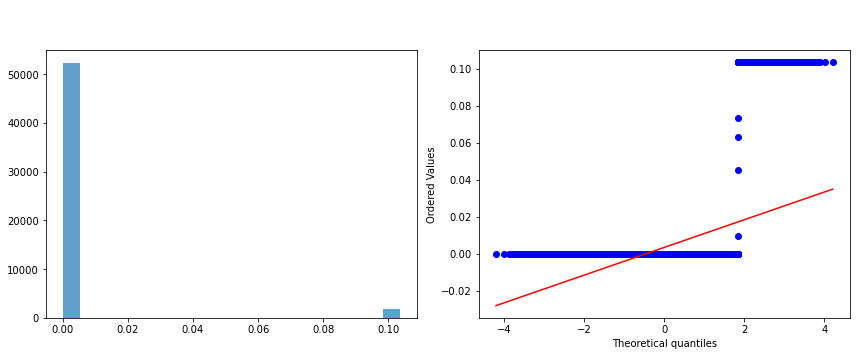

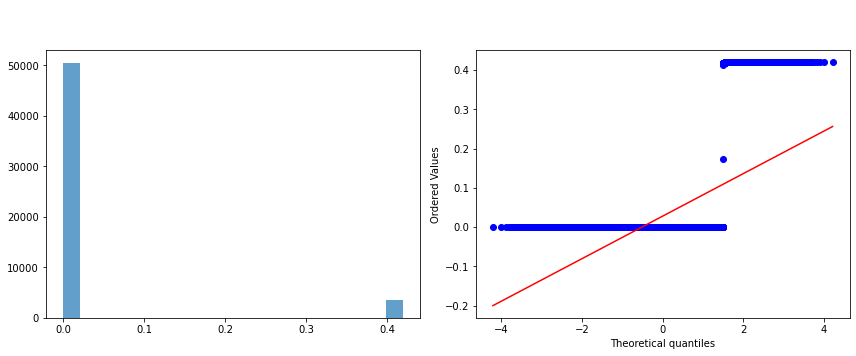

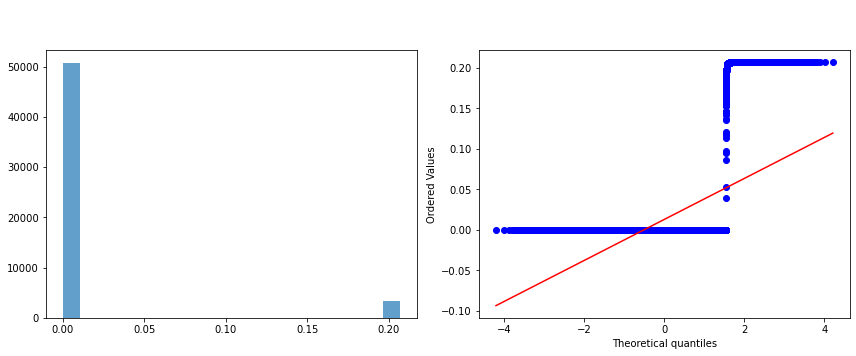

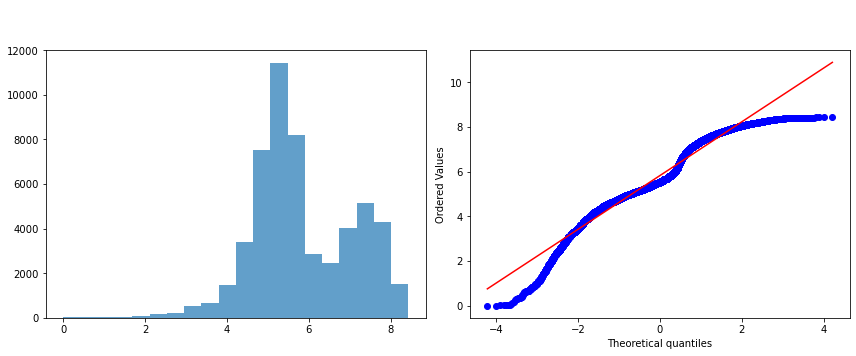

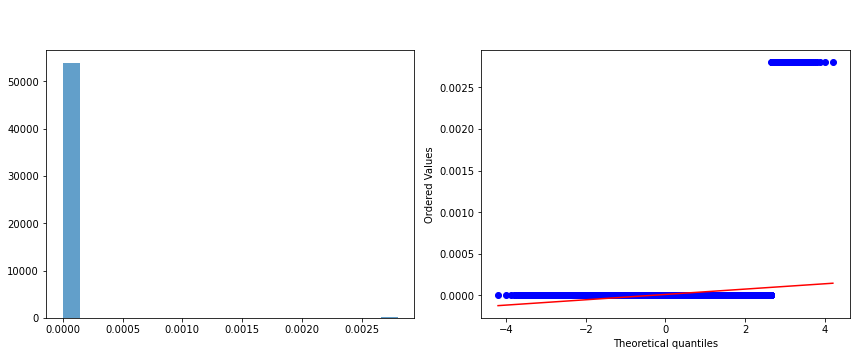

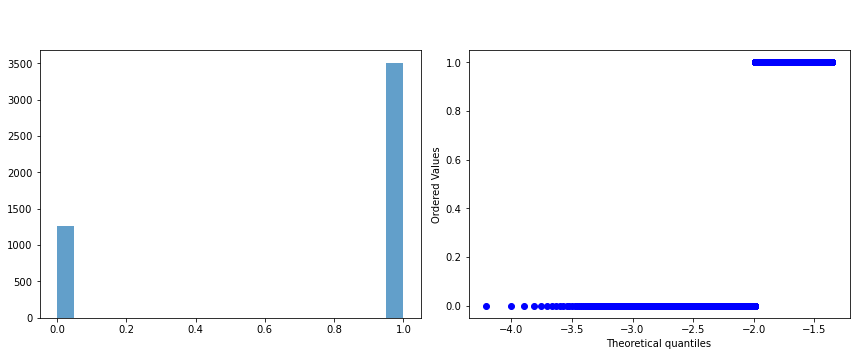

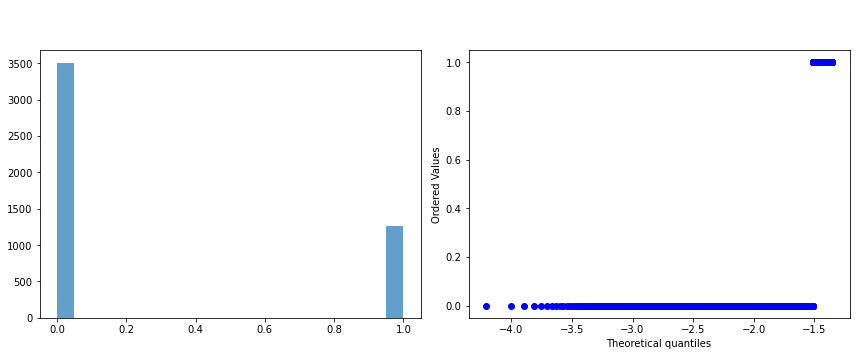

In [26]:
for col in data_for_plotting.df:
    if data_for_plotting.df.dtypes[col] == float or data_for_plotting.df.dtypes[col] == int:
        data_for_plotting.plot_skew(col)
        # data_for_plotting.plot_skew(skew_test_log)

In [13]:
data_for_plotting.df['loan_amount'].isnull().sum()

0

In [18]:
skew_test_log.shape

(54100, 15)

In [78]:
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np

# Assuming 'data' is your DataFrame
# Here's how you might iterate through columns and count outliers based on IQR

def count_outliers_iqr(df):
    outliers_count = {}
    for col in df.columns:
        if df.dtypes[col] == float or df.dtypes[col] == int:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers_count[col] = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    return outliers_count


# Implementing DBSCAN
# Assuming 'data' is your DataFrame

def detect_outliers_dbscan(df, eps, min_samples):
    outliers = {}
    for col in df.columns:
        if df.dtypes[col] == float or df.dtypes[col] == int:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            X = df[col].values.reshape(-1, 1)
            dbscan.fit(X)
            outliers[col] = np.sum(dbscan.labels_ == -1)
    return outliers



In [77]:
outliers_iqr = count_outliers_iqr(data_for_plotting.df)
print(outliers_iqr)

{'Unnamed: 0': 0, 'loan_amount': 1496, 'funded_amount': 1391, 'funded_amount_inv': 1317, 'int_rate': 917, 'installment': 1298, 'employment_length': 0, 'annual_inc': 1126, 'dti': 60, 'delinq_2yrs': 8578, 'inq_last_6mths': 5201, 'open_accounts': 690, 'total_accounts': 1009, 'out_prncp': 6492, 'out_prncp_inv': 6490, 'total_payment': 180, 'total_payment_inv': 1736, 'total_rec_prncp': 2338, 'total_rec_int': 419, 'total_rec_late_fee': 1751, 'recoveries': 3604, 'collection_recovery_fee': 3385, 'last_payment_amount': 6681, 'collections_12_mths_ex_med': 208, '36 months': 0, '60 months': 0}


In [80]:
outliers_dbscan = detect_outliers_dbscan(data_for_plotting.df, eps=0.5, min_samples=5)
print(outliers_dbscan)

In [3]:
data = pd.read_csv("RDS_data.csv", index_col=0)
preprocessed_data = DataPreprocessor(data)

Using regressor to impute for column: funded_amount
Mean Absolute Error: 0.9239763220977447 for predictions on funded_amount column
Imputation for funded_amount complete!
Using classifier to impute for column: term
Mean Absolute Error: 0.8234698013781921 for predictions on term column
Imputation for term complete!
Using regressor to impute for column: int_rate
Mean Absolute Error: 0.0001602850283776348 for predictions on int_rate column
Imputation for int_rate complete!
Transforming skewed columns...


In [5]:
data_for_plotting = Plotter(preprocessed_data.data)

In [4]:
cols_to_gate =['delinq_2yrs',
                    'inq_last_6mths',
                    'out_prncp',
                    'out_prncp_inv',
                    'total_rec_late_fee',
                    'recoveries',
                    'collection_recovery_fee',
                    'collections_12_mths_ex_med']

Mean: 77.28688385741034
Std: 18.698928419968798
Mean + 5*std: 170.78152595725433


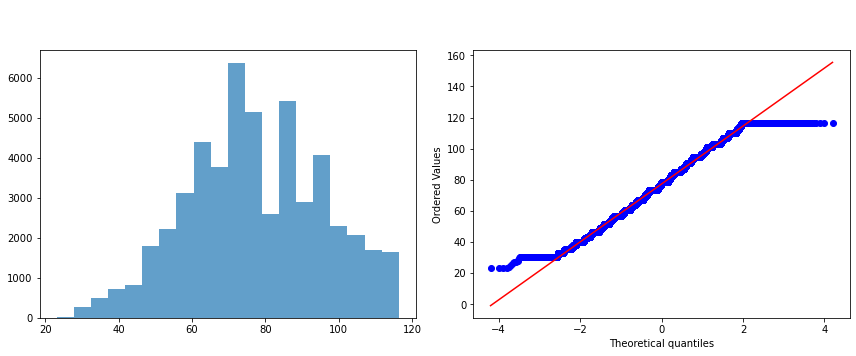

Mean: 92.22624107515601
Std: 22.802465247719507
Mean + 5*std: 206.23856731375355


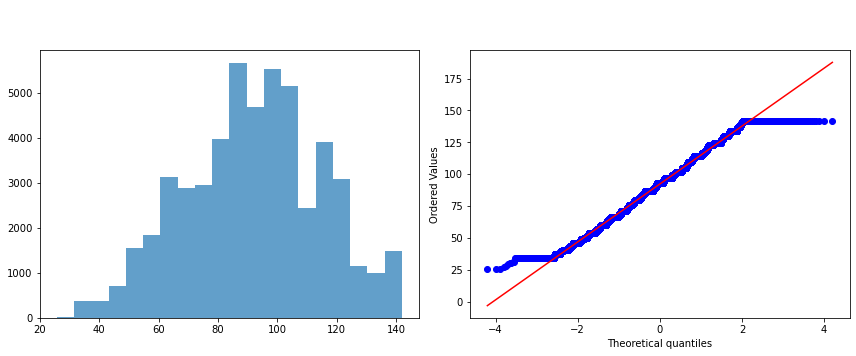

Mean: 131.97328159253428
Std: 39.59497547899367
Mean + 5*std: 329.9481589875026


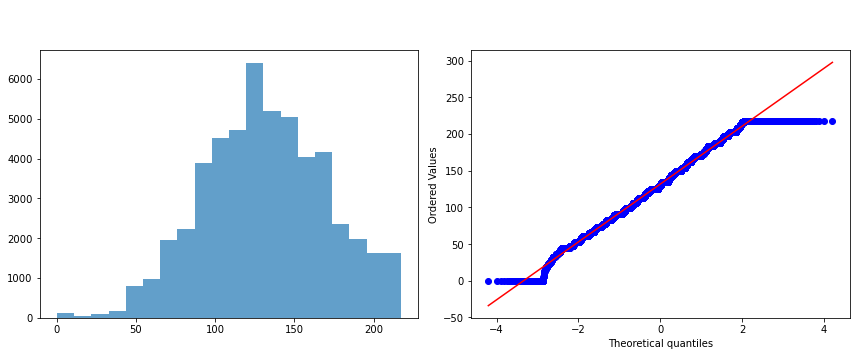

Mean: 4.866782105152426
Std: 0.8948693500718488
Mean + 5*std: 9.34112885551167


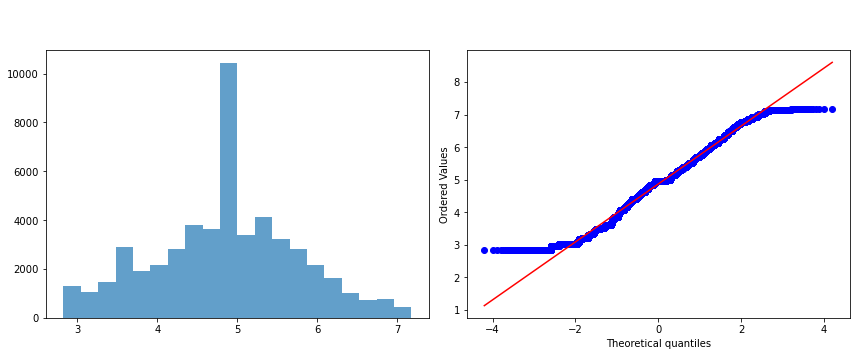

Mean: 18.103930300677025
Std: 4.410136211658965
Mean + 5*std: 40.15461135897185


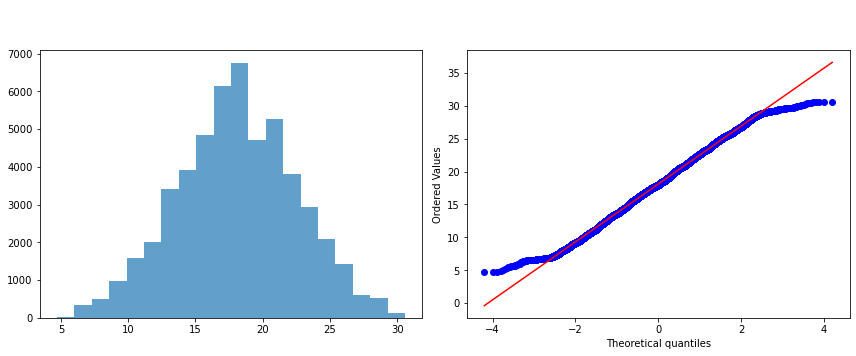

Mean: 7.013370580868895
Std: 5.587078850113831
Mean + 5*std: 34.94876483143805


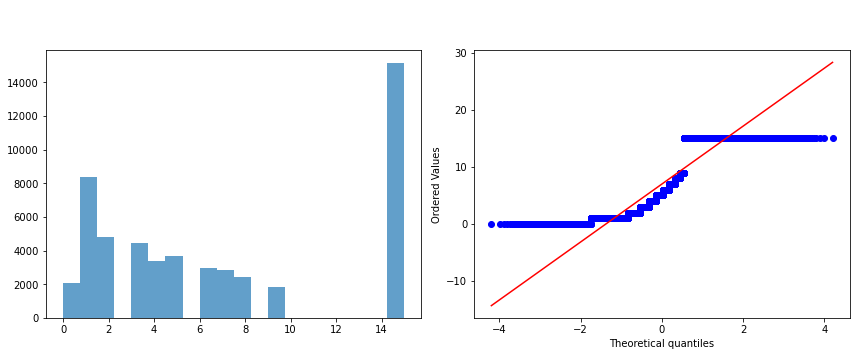

Mean: 9.992550367319444
Std: 0.3689156380736744
Mean + 5*std: 11.837128557687816


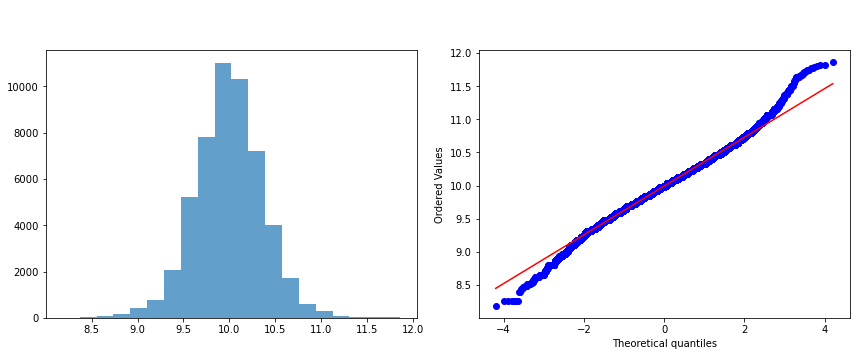

Mean: 9.628883174307784
Std: 3.911299882364324
Mean + 5*std: 29.185382586129403


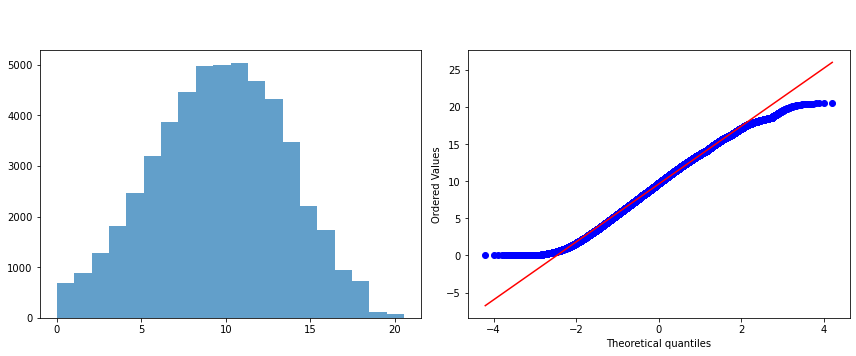

Mean: 0.20011559580001925
Std: 0.528043686263752
Mean + 5*std: 2.840334027118779


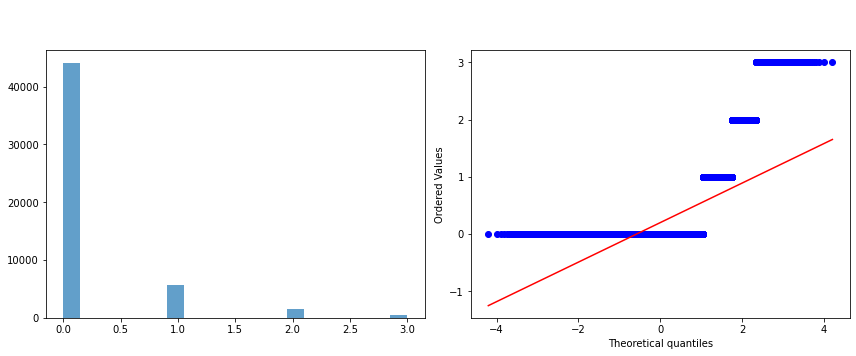

Mean: 0.8613043059435507
Std: 1.1446052504927935
Mean + 5*std: 6.584330558407518


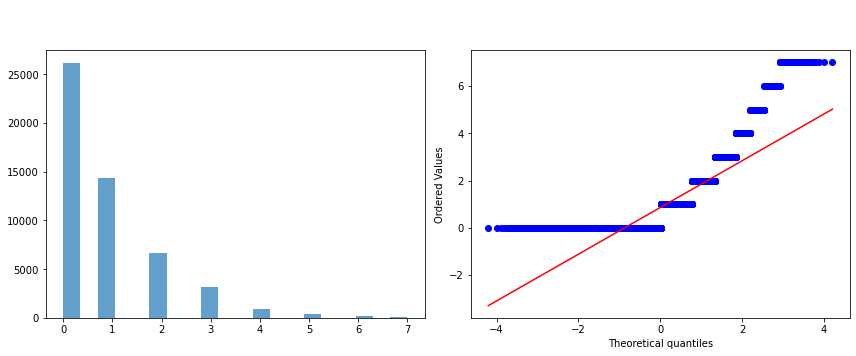

Mean: 3.075827251394763
Std: 0.6792378627737159
Mean + 5*std: 6.472016565263343


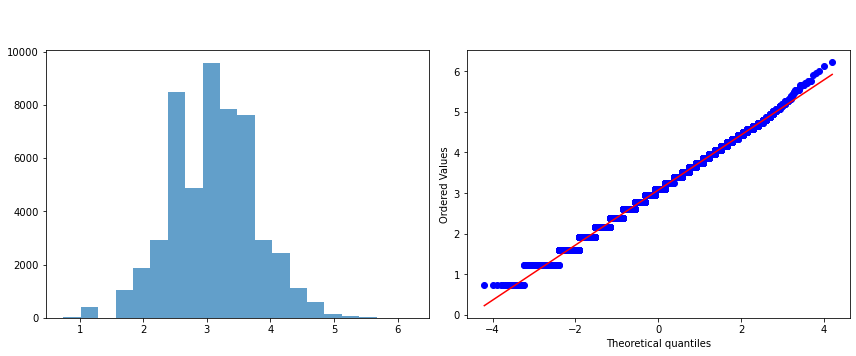

Mean: 5.949979074253806
Std: 1.524024614820006
Mean + 5*std: 13.570102148353836


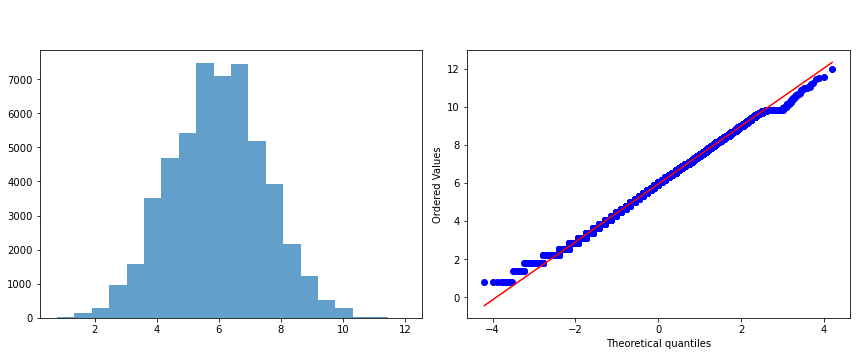

Mean: 2733.71721895771
Std: 5012.853776126752
Mean + 5*std: 27797.986099591468


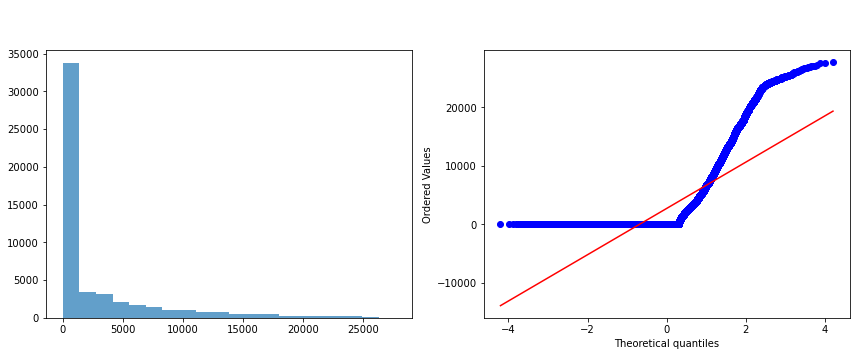

Mean: 2732.3134064155533
Std: 5011.04941792587
Mean + 5*std: 27787.560496044905


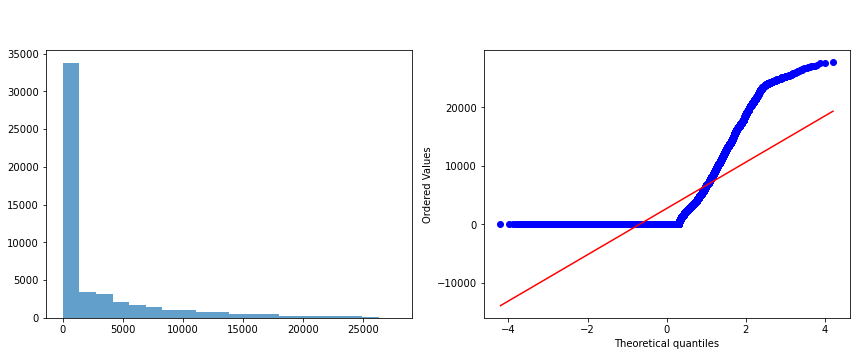

Mean: 49.053494580073945
Std: 11.478051006303296
Mean + 5*std: 106.44374961159042


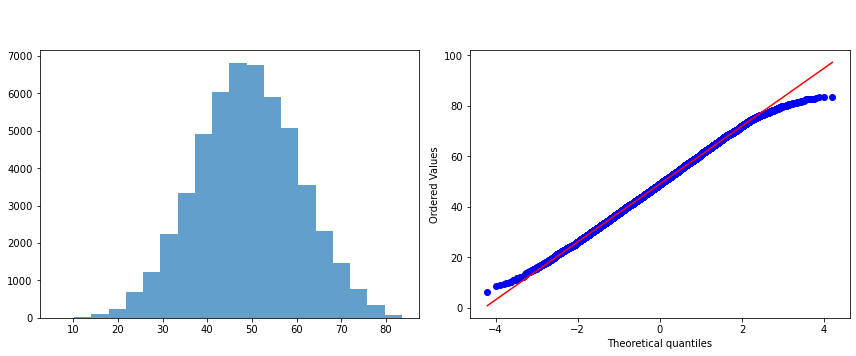

Mean: 76.65883659907031
Std: 22.13159671032911
Mean + 5*std: 187.31682015071584


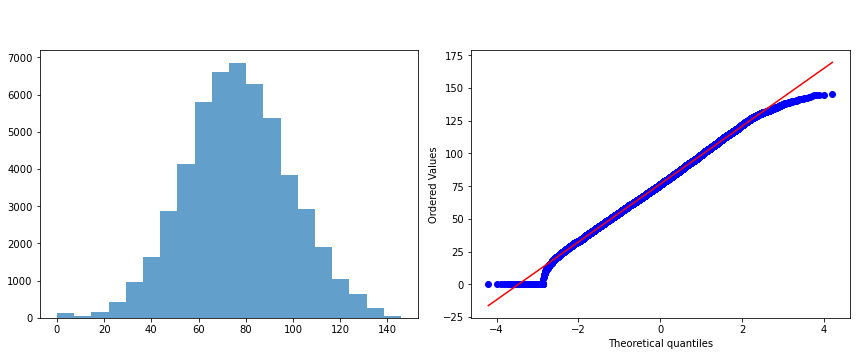

Mean: 49.09624092327087
Std: 12.73702153496643
Mean + 5*std: 112.78134859810302


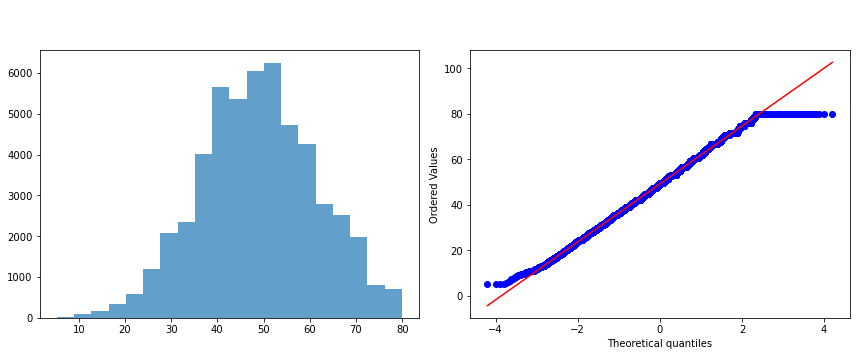

Mean: 14.174327389925876
Std: 3.2205962166807542
Mean + 5*std: 30.277308473329647


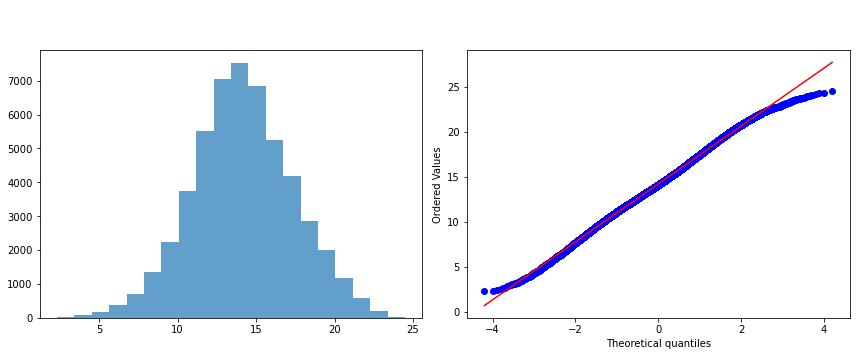

Mean: 0.4463693238237452
Std: 3.018105341137676
Mean + 5*std: 15.536896029512127


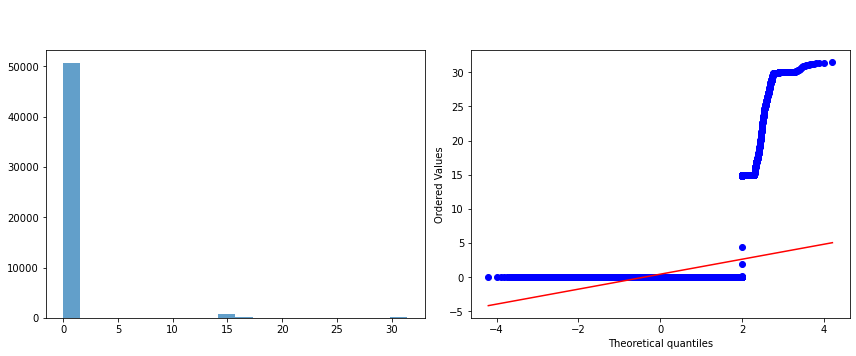

Mean: 30.96334970008047
Std: 200.25390465026052
Mean + 5*std: 1032.2328729513831


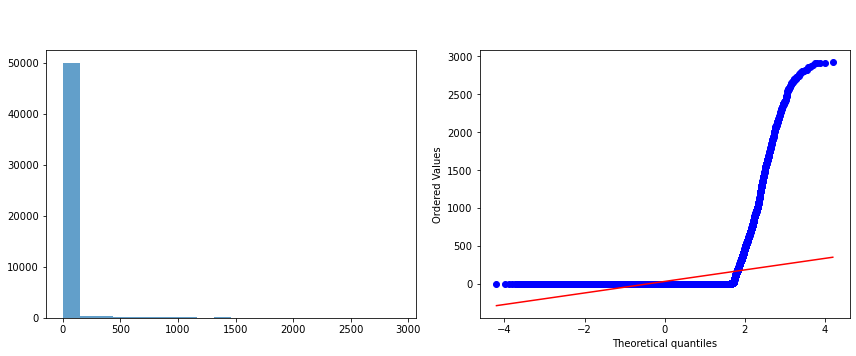

Mean: 0.9502612176106853
Std: 8.961312411806484
Mean + 5*std: 45.756823276643104


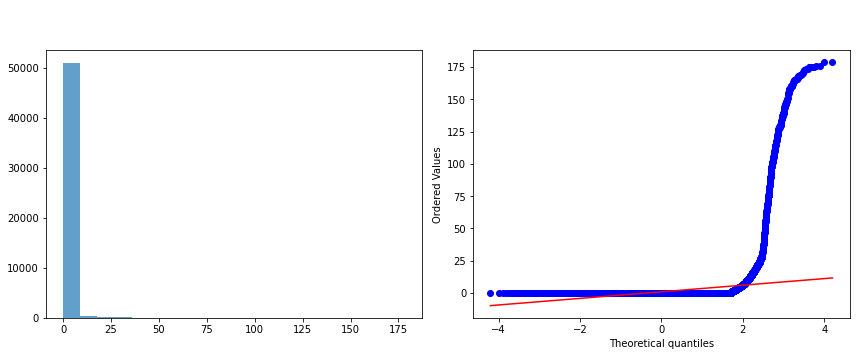

Mean: 6.062327706118269
Std: 1.3094484923159295
Mean + 5*std: 12.609570167697917


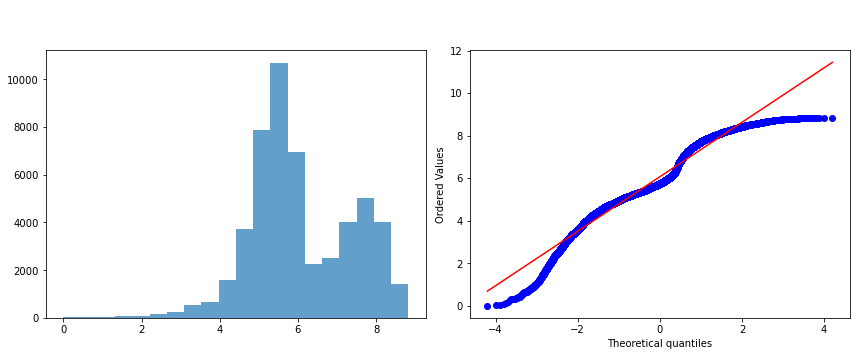

Mean: 0.0
Std: 0.0
Mean + 5*std: 0.0


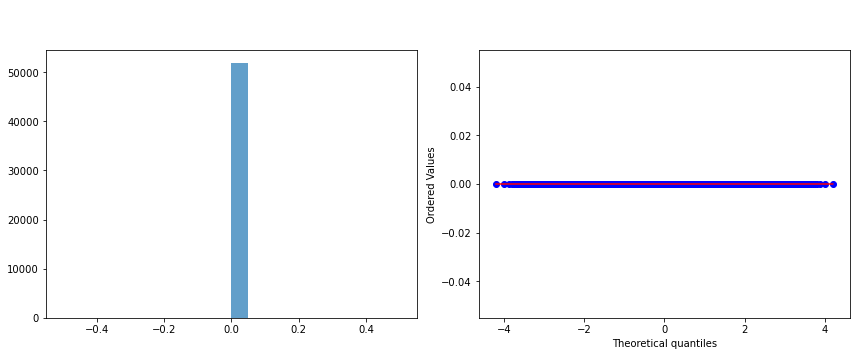

Mean: 0.7388353765323993
Std: 0.43931755409438716
Mean + 5*std: 2.935423147004335


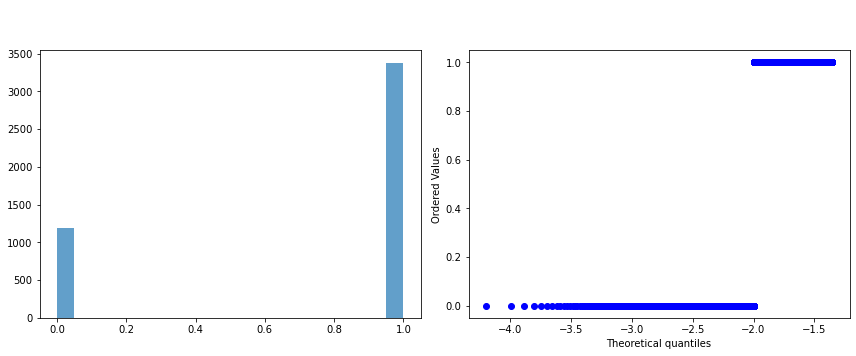

Mean: 0.2609457092819615
Std: 0.43919844444287176
Mean + 5*std: 2.4569379314963204


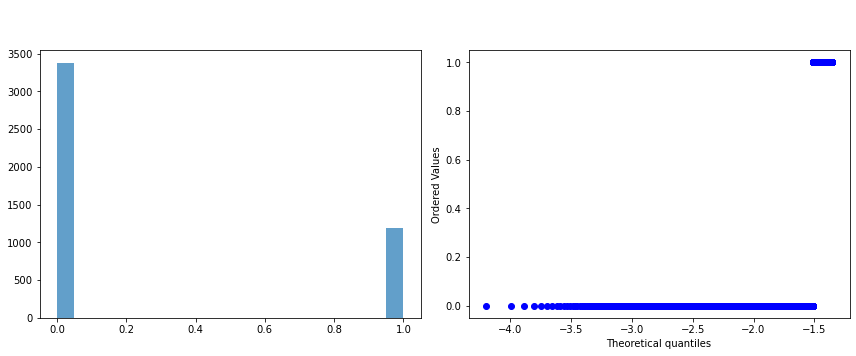

In [6]:
for col in data_for_plotting.df:
    if data_for_plotting.df.dtypes[col] == float or data_for_plotting.df.dtypes[col] == int:
        print(f"Mean: {data_for_plotting.df[col].mean()}")
        print(f"Std: {data_for_plotting.df[col].std()}")
        print(f"Mean + 5*std: {data_for_plotting.df[col].mean()+ 5*data_for_plotting.df[col].std()}")
        data_for_plotting.plot_skew(col)
        # data_for_plotting.plot_skew(skew_test_log)

In [43]:

def count_outliers(df, cols_to_gate):
    outliers_count = {}
    for col in cols_to_gate:
        if df.dtypes[col] == int or df.dtypes[col] == float:
            mean = df[col].mean()
            std_dev = df[col].std()
            lower_limit = mean - 5 * std_dev
            upper_limit = mean + 5 * std_dev
            
            outliers_count[col] = len(df[(df[col] < lower_limit) | (df[col] > upper_limit)])
    
    return outliers_count

In [44]:
outliers = count_outliers(data_for_plotting.df, data_for_plotting.df.columns)

In [45]:
outliers

{'loan_amount': 0,
 'funded_amount': 0,
 'funded_amount_inv': 0,
 'int_rate': 0,
 'installment': 0,
 'employment_length': 0,
 'annual_inc': 196,
 'dti': 0,
 'delinq_2yrs': 419,
 'inq_last_6mths': 128,
 'open_accounts': 45,
 'total_accounts': 7,
 'out_prncp': 114,
 'out_prncp_inv': 114,
 'total_payment': 7,
 'total_payment_inv': 5,
 'total_rec_prncp': 0,
 'total_rec_int': 153,
 'total_rec_late_fee': 422,
 'recoveries': 406,
 'collection_recovery_fee': 262,
 'last_payment_amount': 184,
 'collections_12_mths_ex_med': 208,
 '36 months': 0,
 '60 months': 0}

In [50]:
def drop_outliers(df, threshold=5):
    # outliers_count = 0
    for col in df:
        if df.dtypes[col] == int or df.dtypes[col] == float:
            mean = df[col].mean()
            std = df[col].std()
            outlier_indices = (df[col] - mean).abs() > (threshold * std)
            df = df[~outlier_indices]
    return df


In [51]:
data_for_plotting.df.shape

(54100, 42)

In [52]:
drop_outliers(data_for_plotting.df).shape

(49037, 42)

In [4]:
preprocessed_data.data

,loan_id,member_id,loan_amount,funded_amount,funded_amount_inv,int_rate,installment,loan_grade,loan_sub_grade,employment_length,...,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type,term_36 months,term_60 months,36 months,60 months
0,38676116,41461848,68.035128,78.513026,118.808928,3.499672,16.117666,A,A4,5,...,2022-01-01,4.910558,2022-01-01,0.0,1,INDIVIDUAL,1,0,NaN,NaN
1,38656203,41440010,82.041962,95.619243,148.884026,3.350011,19.560311,A,A3,9,...,2022-01-01,5.293713,2022-01-01,0.0,1,INDIVIDUAL,1,0,NaN,NaN
2,38656154,41439961,88.131719,103.111384,162.331750,3.499672,21.126552,A,A4,8,...,2021-10-01,7.763081,2021-10-01,0.0,1,INDIVIDUAL,1,0,NaN,NaN
3,38656128,41439934,86.041425,100.536226,157.691827,5.174915,21.405264,C,C4,1,...,2021-06-01,7.815112,2021-06-01,0.0,1,INDIVIDUAL,1,0,NaN,NaN
4,38656121,41439927,86.041425,100.536226,157.691827,3.046860,20.437850,A,A1,15,...,2022-01-01,5.380851,2022-01-01,0.0,1,INDIVIDUAL,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54190,123133,114358,76.777350,89.168155,49.506791,5.511267,19.196799,F,F4,3,...,2014-05-01,5.256468,2022-01-01,0.0,1,INDIVIDUAL,1,0,NaN,NaN
54199,55521,107577,30.698676,34.049136,0.000000,5.534983,6.982478,F,F2,1,...,2016-03-01,5.507458,2016-03-01,0.0,1,INDIVIDUAL,1,0,NaN,NaN
54203,185352,105254,61.061065,70.068996,33.294105,4.091641,14.545483,B,B4,1,...,2016-12-01,4.712596,2016-12-01,0.0,1,INDIVIDUAL,1,0,NaN,NaN
54204,122637,104675,52.382538,59.639103,56.261081,3.575506,12.179723,A,A3,1,...,2016-09-01,4.371804,2016-08-01,0.0,1,INDIVIDUAL,1,0,NaN,NaN


<AxesSubplot:>

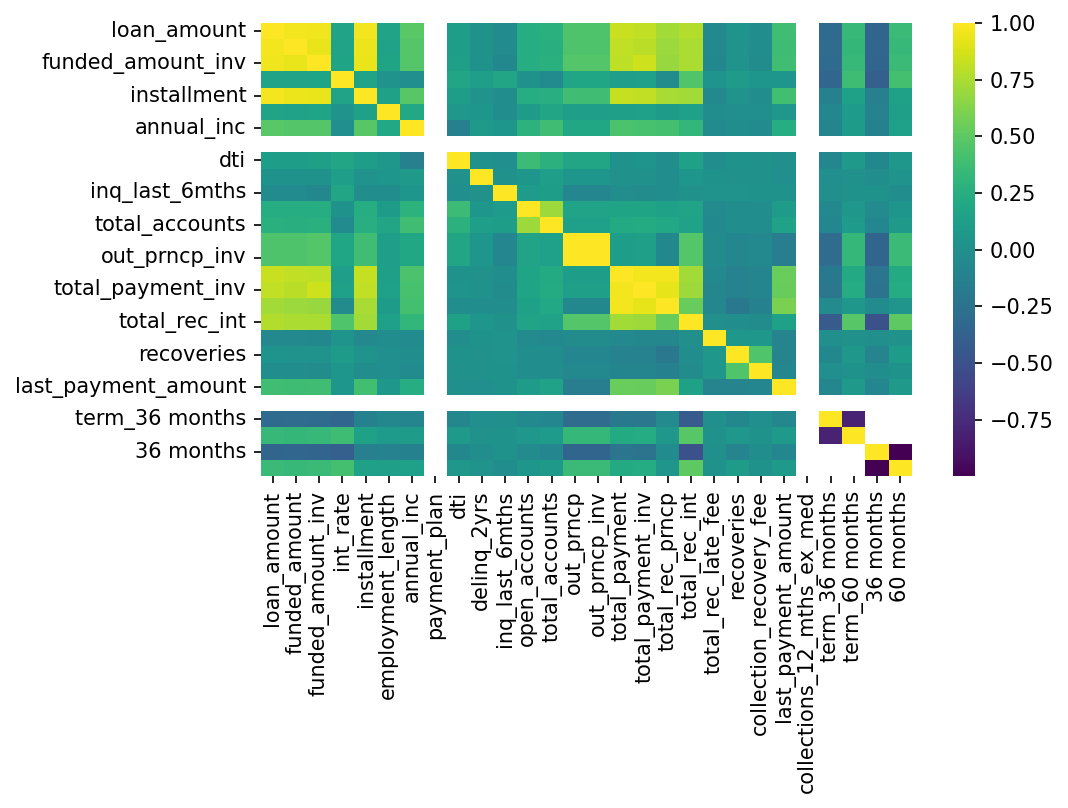

In [5]:
plt.figure(figsize=(7,4),dpi=150)
sns.heatmap(preprocessed_data.data.corr(), cmap = 'viridis')

In [26]:
# for col in preprocessed_data.data.corr():
def count_high_correlations(df, threshold=0.9):
    corr_matrix = df.corr().abs()  # Get the absolute correlation matrix
    high_corr_count = {}
    
    for column in corr_matrix:
        high_corr_count[column] = len(corr_matrix[column][corr_matrix[column] > threshold]) - 1  # Exclude self-correlation
    
    return high_corr_count

print(count_high_correlations(preprocessed_data.data.drop(['funded_amount', 'funded_amount_inv','out_prncp_inv','total_payment_inv','installment','total_rec_prncp','60 months'], axis=1)))
    

{'loan_amount': 0, 'int_rate': 0, 'employment_length': 0, 'annual_inc': 0, 'payment_plan': -1, 'dti': 0, 'delinq_2yrs': 0, 'inq_last_6mths': 0, 'open_accounts': 0, 'total_accounts': 0, 'out_prncp': 0, 'total_payment': 0, 'total_rec_int': 0, 'total_rec_late_fee': 0, 'recoveries': 0, 'collection_recovery_fee': 0, 'last_payment_amount': 0, 'collections_12_mths_ex_med': -1, 'term_36 months': 0, 'term_60 months': 0, '36 months': 0}


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

from sklearn.preprocessing import OneHotEncoder

def calculate_vif_with_encoding(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # One-hot encode non-numeric columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    if categorical_cols:
        encoder = OneHotEncoder(drop='first', sparse=False)
        encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
        df = pd.concat([df[numerical_cols], encoded_cols], axis=1)

    return calculate_vif(df)

def plot_vif_heatmap(df):
    vif_scores = calculate_vif_with_encoding(df)
    vif_scores.set_index('Feature', inplace=True)
    sns.heatmap(vif_scores, annot=True, cmap='coolwarm')

In [13]:
calculate_vif_with_encoding(preprocessed_data.data)

MemoryError: Unable to allocate 40.5 GiB for an array with shape (51905, 104711) and data type float64